In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import time
import math

from torch.utils.data import DataLoader

import torch
import torch.nn as nn

%matplotlib inline

torch.manual_seed(1)
np.random.seed(1)
random.seed(1)

gpu = "0"
os.environ["CUDA_VISIBLE_DEVICES"] = gpu

import sys
# Get the previous folder and append it to sys.path
PATH = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(PATH)

from config import DATAFOLDER

In [2]:
src_domain = 'FSeg'
tgt_domain = 'Thebe'

da_method = 'FDA'
Lb = 0.1
fda_imgs = 1024

# data
red = 0 # reduction factor
n_imgs = 32000  # {3200, 6400} max: 51200
bs = 16 # batch size
type_aug = "type1_fda" # type0, type1
nw = 1 # num_workers

# model
net = "at-unet" # unet2d / dexined
f = 16 # filters on first layer -> unet
n_blocks = 3  # blocks on encode / decode -> unet
bn = False # batch normalization
dropout = False

# training
optimizer = 'Adam'
lr = 1e-4
lr_adjust = False
epochs = 15 # 100
loss = 'BCE'

# -----------------------------------------------------------------------------
config_keys = [k for k,v in globals().items() if not k.startswith('_') and isinstance(v, (int, float, bool, str))]
config = {k: globals()[k] for k in config_keys} # will be useful for logging

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Load Data

In [4]:
from dataloaders import ThebeGenerator, FaultSeg2DGenerator

In [5]:
dataset = 'Thebe'
DATAPATH = os.path.join(DATAFOLDER, dataset)

ps = '256to128' # patch size
step = 3 # step size

DATAPATH_TH_SRC = os.path.join(DATAPATH, 'Patches2D', 'src_ps{}_step{}'.format(ps, step) )
DATAPATH_TH_TGT = os.path.join(DATAPATH, 'Patches2D', 'tgt_ps{}_step{}'.format(ps, step) )

train_gen_TH = ThebeGenerator(DATAPATH_TH_TGT, "train", red=red, n_imgs=n_imgs) #, aug=type_aug)
val_gen_TH = ThebeGenerator(DATAPATH_TH_SRC, "val", red=red, n_imgs=n_imgs)
len(train_gen_TH.list_IDs) # max. 49770

32000

In [6]:
# extract references images from target domain
ref_imgs=[]
for idx, (x,_) in enumerate(train_gen_TH):
    ref_imgs.append(x[0])
    if idx == fda_imgs:
        break

In [7]:
dataset = 'FaultSeg3D'
DATAPATH_FS = os.path.join(DATAFOLDER, dataset)

train_gen_FS = FaultSeg2DGenerator(DATAPATH_FS, "train", red=red, n_imgs=n_imgs, aug=type_aug,
                                  ref_imgs=ref_imgs, Lb=Lb)
val_gen_FS = FaultSeg2DGenerator(DATAPATH_FS, "val", red=red, n_imgs=n_imgs)
len(train_gen_FS.list_IDs) # 51200

25600

In [8]:
# shuffle = False
train_tgt = DataLoader(dataset=train_gen_TH, batch_size=bs, shuffle=False, drop_last=True, num_workers=nw)
val_tgt = DataLoader(dataset=val_gen_TH, batch_size=bs, shuffle=False, drop_last=True, num_workers=nw)

train_src = DataLoader(dataset=train_gen_FS, batch_size=bs, shuffle=True, drop_last=True, num_workers=nw)
val_src = DataLoader(dataset=val_gen_FS, batch_size=bs, shuffle=False, drop_last=True, num_workers=nw)

## Modeling

In [9]:
from models.at_unet import AtrousUNet

model = AtrousUNet(f1=f, depth=4).to(device)
# summary(model, input_size=(1, 128, 128))

In [10]:
opt = torch.optim.Adam(model.parameters(), lr=lr)

criterion = nn.BCELoss()

## Training

In [11]:
from metrics import *

In [12]:
# saved_name = wandb.run.id
# saved_path = os.path.join(PATH, 'res', '{}.pt'.format(saved_name))
# wandb.config.update({"saved_path": saved_name})

saved_path = "delete.pt"

stopPatience = 10
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, 'min', factor=0.1, patience=stopPatience//2, verbose=True)
saved_path

'delete.pt'

In [13]:
def process(load_src, load_tgt, model, phase='train', opt=None, epoch=0):

    task_loss_ = 0.0
    
    iou_ = 0.0
    iou_tgt_ = 0.
    iou_tgt = 0. # NO DELETE
    
    if phase=='train':
        model.train()  
    else:
        model.eval()
        
    epoch += 1
    
    if phase=='train':
        model.train() 
        if lr_adjust:
            for param_group in opt.param_groups:
                param_group['lr'] = lr / math.pow((1 + 10 * (epoch - 1) / epochs), 0.75)
    else:
        model.eval()
    
    for step_, ((x_src, y_src), (x_tgt, y_tgt)) in enumerate(zip(load_src, load_tgt)):
        
        # make images variable
        x_src = x_src.float().to(device=device)
        y_src = y_src.to(device=device).unsqueeze(1)

        # source domain
        src_class_output = model(x_src)
        src_loss_class = criterion(src_class_output, y_src)
        
        if phase=='train':
            # calculate the gradients
            opt.zero_grad()
            src_loss_class.backward()

            # update weigths
            opt.step()
        
        ## compute loss
        task_loss_ += src_loss_class.item()
        
        ## compute metrics
        pred_ = (src_class_output > 0.5).float() 
        iou_ += compute_iou(pred_.squeeze(1), y_src.squeeze(1))
        
        if phase=='val':

            # make images variable
            x_tgt = x_tgt.float().to(device=device)
            y_tgt = y_tgt.to(device=device).unsqueeze(1)

            # target domain
            tgt_class_output = model(x_tgt)

            pred_2 = (tgt_class_output > 0.5).float()
            iou_tgt_ += compute_iou(pred_2.squeeze(1), y_tgt.squeeze(1))        
        
    task_loss = task_loss_/(step_+1)
    iou = iou_/(step_+1)
    
    if phase=='val':
        iou_tgt = iou_tgt_/(step_+1)
        scheduler.step(task_loss)
        
    return task_loss, iou, iou_tgt

In [14]:
min_valid_loss = np.inf
max_valid_vl = -np.inf
n_patience = 0
t_start = time.time()
t_start_total = time.time()

for ep in range(epochs):
    
    task_loss_tr, iou_src_tr, iou_tgt_tr = process(train_src, train_tgt, model, phase='train', opt=opt, epoch=ep)

    with torch.no_grad():
        task_loss_vl, iou_src_vl, iou_tgt_vl = process(val_src, val_tgt, model, phase='val', epoch=ep)
        
    t_ = time.time()-t_start

    for param_group in opt.param_groups:
        lr_step = param_group['lr']
    
    # wandb.log({
    #     "train/epoch/time": t_,
    #     "train/epoch/step": ep+1,
    #     "lr/step": lr_step,
        
    #     "train/epoch/task_loss": task_loss_tr,
    #     "train/epoch/iou/src": iou_src_tr,
        
    #     "val/epoch/task_loss": task_loss_vl,
    #     "val/epoch/iou/src": iou_src_vl,
    #     "val/epoch/iou/tgt": iou_tgt_vl

    # })
    

    print('Epoch {}:   {:.1f}s - loss: {:.4f} - iou_src: {:.4f}'.format(ep+1, t_, task_loss_tr, iou_src_tr))
    print('                   val_loss: {:.4f} - val_iou_src: {:.4f} - val_iou_tgt: {:.4f}'.format(task_loss_vl, iou_src_vl, iou_tgt_vl))
#     print('')

    loss_vl = task_loss_vl
    
    if min_valid_loss > loss_vl:
        print(f'val_loss improved from {min_valid_loss:.6f} to {loss_vl:.6f} , saving model\n')
        min_valid_loss = loss_vl
        torch.save(model.state_dict(), saved_path)
        n_patience=0
    else:
        print(f'val_loss did not improve from {min_valid_loss:.6f}\n')
        n_patience+=1
        if n_patience==stopPatience:
            print('Epoch {}:   early stopping'.format(ep+1))
            break
            
    t_start = time.time()
    
t_total = time.time() - t_start_total

Epoch 1:   107.6s - loss: 0.2680 - iou_src: 0.0000
                   val_loss: 0.2504 - val_iou_src: 0.0000 - val_iou_tgt: 0.0000
val_loss improved from inf to 0.250425 , saving model

Epoch 2:   106.5s - loss: 0.2373 - iou_src: 0.0004
                   val_loss: 0.2219 - val_iou_src: 0.0221 - val_iou_tgt: 0.0265
val_loss improved from 0.250425 to 0.221875 , saving model

Epoch 3:   107.7s - loss: 0.2018 - iou_src: 0.1224
                   val_loss: 0.1818 - val_iou_src: 0.2697 - val_iou_tgt: 0.1659
val_loss improved from 0.221875 to 0.181757 , saving model

Epoch 4:   108.1s - loss: 0.1747 - iou_src: 0.2565
                   val_loss: 0.1697 - val_iou_src: 0.3384 - val_iou_tgt: 0.1661
val_loss improved from 0.181757 to 0.169746 , saving model

Epoch 5:   109.2s - loss: 0.1625 - iou_src: 0.2989
                   val_loss: 0.1625 - val_iou_src: 0.3409 - val_iou_tgt: 0.1628
val_loss improved from 0.169746 to 0.162482 , saving model

Epoch 6:   109.5s - loss: 0.1556 - iou_src: 0.3216

In [15]:
t_total/60, ep

(27.240890832742057, 14)

## Validation

In [16]:
model.load_state_dict(torch.load(saved_path))
model.eval()
print()

In [17]:
for idx, (x_tgt, y_tgt) in enumerate(val_tgt):
    print(x_tgt.shape, y_tgt.shape)
    break

torch.Size([16, 1, 128, 128]) torch.Size([16, 128, 128])


In [18]:
y_tgt_prob = model(x_tgt.float().to(device)).cpu().detach().numpy()
y_tgt_pred = np.where(y_tgt_prob[:,0] >= 0.5, 1, 0)
y_tgt_prob.shape, y_tgt_pred.shape

((16, 1, 128, 128), (16, 128, 128))

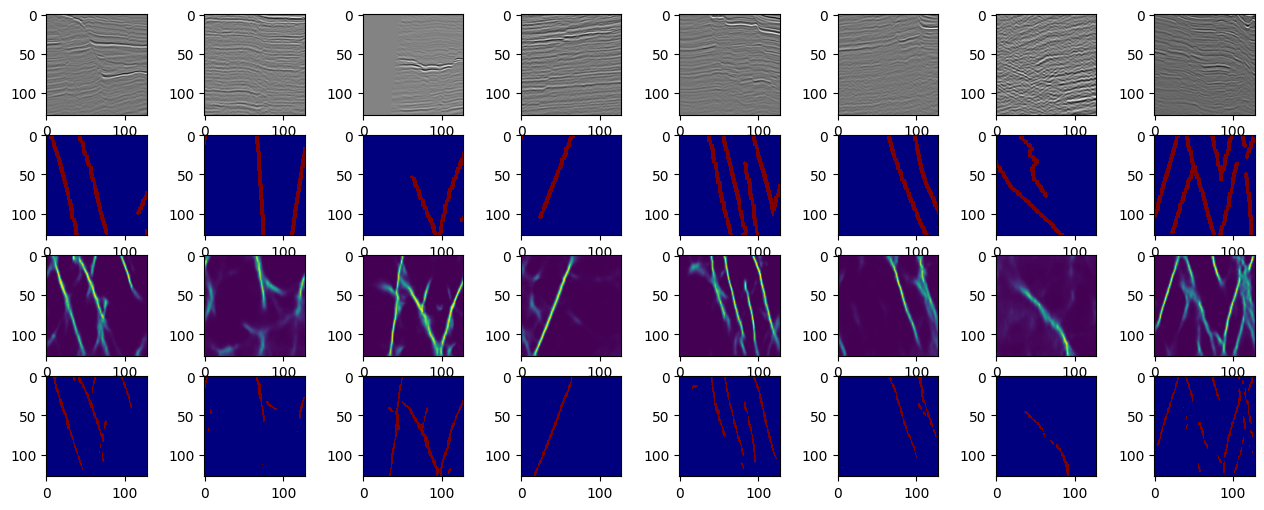

In [19]:
fig, axes = plt.subplots(4, 8, figsize=[16,6])

for i in range(8):
    axes[0, i].imshow(x_tgt[i,0], cmap="gray")
    axes[1, i].imshow(y_tgt[i], cmap="jet", interpolation="nearest")
    axes[2, i].imshow(y_tgt_prob[i,0])
    axes[3, i].imshow(y_tgt_pred[i], cmap="jet", interpolation="nearest")
    
# wandb.log({"valid/imgs_tgt": fig})

### Metrics

In [20]:
import pandas as pd
from tqdm import tqdm

In [21]:
val_tgt = DataLoader(dataset=val_gen_TH, batch_size=128, shuffle=False, drop_last=True,
                     num_workers=2)

y_true_list = []
y_prob_list = []
for x_tgt, y_tgt in tqdm(val_tgt):
    y_tgt = y_tgt.cpu().detach().numpy()
    y_prob = model(x_tgt.float().to(device)).cpu().detach().numpy() # probs
    
    y_true_list.append(y_tgt)
    y_prob_list.append(y_prob[:,0])
    
y_true_total = np.vstack(y_true_list)  #.ravel()
y_prob_total = np.vstack(y_prob_list) #.ravel()
y_pred_total = np.where(y_prob_total >= 0.5, 1, 0)

y_true_total.shape

100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:06<00:00,  5.49it/s]


(4352, 128, 128)

In [22]:
th_range = np.arange(0, 1, 0.02)
metrics_list = []

y_true = torch.tensor(y_true_total, dtype=torch.float32).to(device)
y_prob = torch.tensor(y_prob_total, dtype=torch.float32).to(device)

for th in th_range:
    pr, re, f1 = binary_classification_metrics(y_prob, y_true, th)
    metrics_list.append([pr, re, f1])

In [23]:
df = pd.DataFrame(np.array(metrics_list)).reset_index(drop=True)
df.columns = ['precision', 'recall', 'f1_score']
df.index = th_range

In [24]:
f1_ = df.loc[0.5]['f1_score']
# wandb.log({"valid/f1_tgt": f1_})

In [25]:
iou = compute_iou(y_true.contiguous(), (y_prob > 0.5).float())
# wandb.log({"valid/iou_tgt": iou})

In [26]:
print("Original:  IoU: {:.4f}   F1-score: {:.4f}".format(iou, f1_))

Original:  IoU: 0.1924   F1-score: 0.3227


### New Metrics

In [27]:
getNewMetrics(y_true_total, y_pred_total, sigma=1) #, wandb=wandb)

339it [00:00, 840.90it/s]C:\Users\Usuario\Documents\Mestrado\Tesis\src\UDAforFaultDetection\metrics.py:94: RuntimeWarning: invalid value encountered in scalar divide
  return np.sum(d)/np.sum(n)
508it [00:00, 841.86it/s]C:\Users\Usuario\Documents\Mestrado\Tesis\src\UDAforFaultDetection\metrics.py:157: RuntimeWarning: divide by zero encountered in scalar divide
  iou = 1/(1/recall+1/precision-1)
C:\Users\Usuario\Documents\Mestrado\Tesis\src\UDAforFaultDetection\metrics.py:158: RuntimeWarning: divide by zero encountered in scalar divide
  f1 = 2/(1/recall+1/precision)
4352it [00:05, 837.34it/s]

With Sigma=1:  IoU: 0.2698   F1-score: 0.3990


In [28]:
getNewMetrics(y_true_total, y_pred_total, sigma=4) #, wandb=wandb)

4352it [00:04, 1051.32it/s]

With Sigma=4:  IoU: 0.4783   F1-score: 0.6117


In [29]:
getNewMetrics(y_true_total, y_pred_total, sigma=7) #, wandb=wandb)

4352it [00:04, 1055.03it/s]

With Sigma=7:  IoU: 0.5672   F1-score: 0.6916
